In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
# import seaborn as sns
import sklearn
import xgboost as xgb
from datetime import datetime
from sklearn import linear_model, feature_extraction, preprocessing, cross_validation, grid_search, metrics, svm, tree, ensemble

%matplotlib inline

In [2]:
train_data = pd.read_csv("train.csv", index_col='AnimalID')
test_data = pd.read_csv("test.csv", index_col='ID')
print(train_data.shape)
print(test_data.shape)

(26729, 9)
(11456, 7)


In [3]:
train_data[:5]

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
def flatten(df, fields):
    for field in fields:
        df = df.join(pd.get_dummies(df[field]), lsuffix='_left', rsuffix='_right')
    return remove(df, fields)

def remove(df, fields):
    return df.drop(fields, axis=1)

def convert_date(dt):
    d = datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")
    return d.year, d.month, d.isoweekday()

In [5]:
all_data = pd.concat([train_data, test_data])

In [6]:
ll = list(map(lambda x: x.split('/'), all_data['Color'].unique()))
l = [item for sublist in ll for item in sublist]
full_color = set(map(lambda x: x.replace(' Mix', ''), l))

In [7]:
ll = list(map(lambda x: x.split('/'), all_data['Breed'].unique()))
l = [item for sublist in ll for item in sublist]
full_breed = set(map(lambda x: x.replace(' Mix', ''), l))

In [8]:
def prepare_breed(df: pd.DataFrame):
    df['BreedMix'] = df['Breed'].str.contains('Mix').apply(lambda x: int(x))
    df['Breed'] = df['Breed'].apply(lambda x: x.replace(' Mix', '').split('/'))
    df['BreedCount'] = df['Breed'].apply(lambda x: len(x))
    tmp = pd.DataFrame()
    for breed in full_breed:
        tmp['Breed ' + breed] = df['Breed'].apply(lambda x: int(breed in x))   
    df = remove(df, ['Breed'])  
    return pd.concat([df, tmp], axis=1)

In [9]:
def prepare_color(df: pd.DataFrame):
    df['Color'] = df['Color'].apply(lambda x: x.split('/'))
    df['ColorCount'] = df['Color'].apply(lambda x: len(x))
    tmp = pd.DataFrame()
    for color in full_color:
        tmp['Color ' + color] = df['Color'].apply(lambda x: int(color in x))
    return pd.concat([df, tmp], axis=1)

In [37]:
def to_days(x):
    r = x
    if type(x) is str:
        s = x.split(' ')
        if s[1] in ('year', 'years'):
            r = int(s[0]) * 365
        elif s[1] in ('month', 'months'):
            r = int(s[0]) * 30
        elif s[1] in ('week', 'weeks'):
            r = int(s[0]) * 7
        else:
            r = int(s[0])

    return r


def prepare_age(df: pd.DataFrame):
    df['AgeuponOutcome'] = df['AgeuponOutcome'].apply(to_days)
    df['AgeuponOutcome'] = df['AgeuponOutcome'].fillna(df['AgeuponOutcome'].mean())
#     df['AgeuponOutcome'] = pd.cut(df['AgeuponOutcome'], bins=[-1000, 30, 90, 10000])
#     df['AgeuponOutcome'] = df['AgeuponOutcome'].str.replace(']', ')')
    return df

In [38]:
def has_name(x):
    return 0 if x == 'Unknown' else 1


def prepare_name(df: pd.DataFrame):
    df['Name'].fillna('Unknown', inplace=True)
    df['Name'] = df['Name'].apply(has_name)
    return df

In [39]:
def prepare_date(df: pd.DataFrame):
    df["Year"], df["Month"], df["WeekDay"] = zip(*df["DateTime"].map(convert_date))
    return df

In [40]:
all_data = pd.concat([train_data, test_data])
all_df = prepare_age(all_data)
all_df = prepare_name(all_df)
all_df = prepare_date(all_df)
all_df = prepare_breed(all_df)
all_df = prepare_color(all_df)
all_df[:3]

,AgeuponOutcome,AnimalType,Color,DateTime,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,Year,Month,...,Color Tortie,Color Ruddy,Color Tan,Color Yellow,Color Gray,Color Black,Color Brown Tiger,Color White,Color Blue Tabby,Color Seal Point
A671945,365,Dog,"[Brown, White]",2014-02-12 18:22:00,1,NaN,Return_to_owner,Neutered Male,2014,2,...,0,0,0,0,0,0,0,1,0,0
A656520,365,Cat,[Cream Tabby],2013-10-13 12:44:00,1,Suffering,Euthanasia,Spayed Female,2013,10,...,0,0,0,0,0,0,0,0,0,0
A686464,730,Dog,"[Blue, White]",2015-01-31 12:28:00,1,Foster,Adoption,Neutered Male,2015,1,...,0,0,0,0,0,0,0,1,0,0


In [97]:
train = all_data[all_df['OutcomeType'].notnull()]
train['OutcomeType'].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

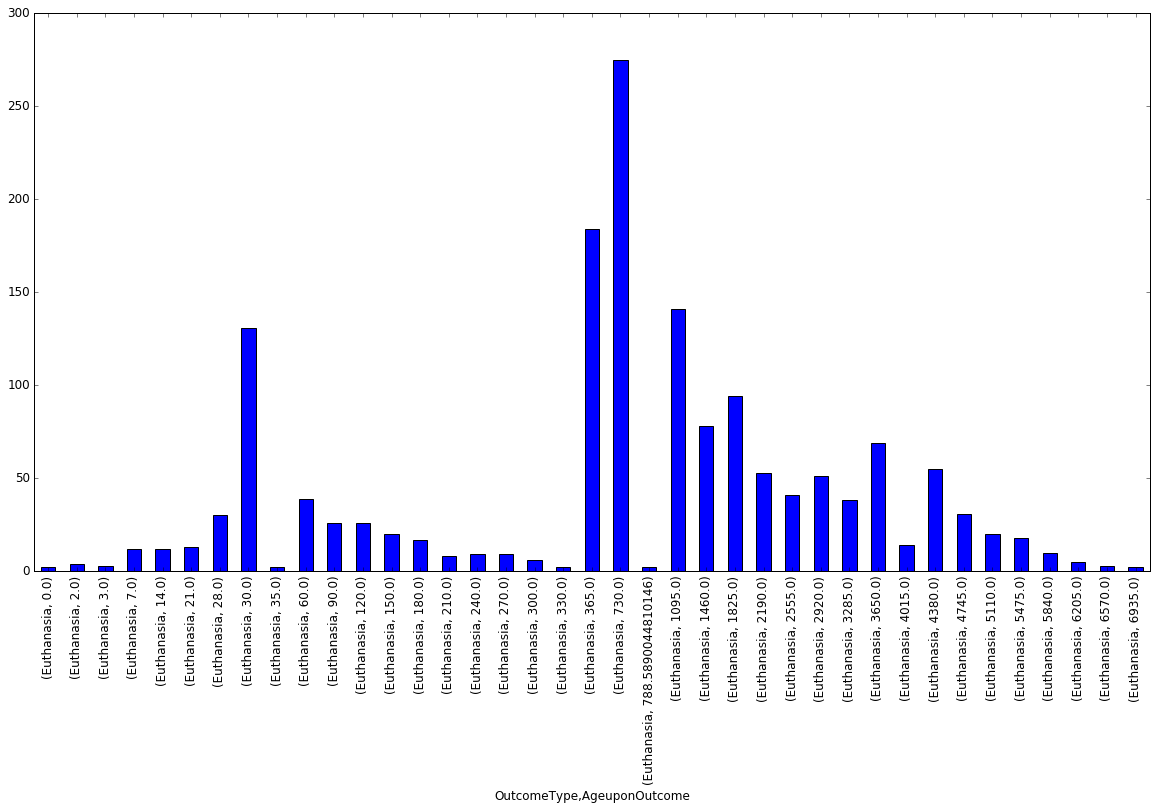

In [95]:
age = train[['OutcomeType', 'AgeuponOutcome']]
grouped = age[train['OutcomeType'] == 'Euthanasia'].groupby(['OutcomeType', 'AgeuponOutcome'])
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 20, 10
grouped.size().plot.bar()

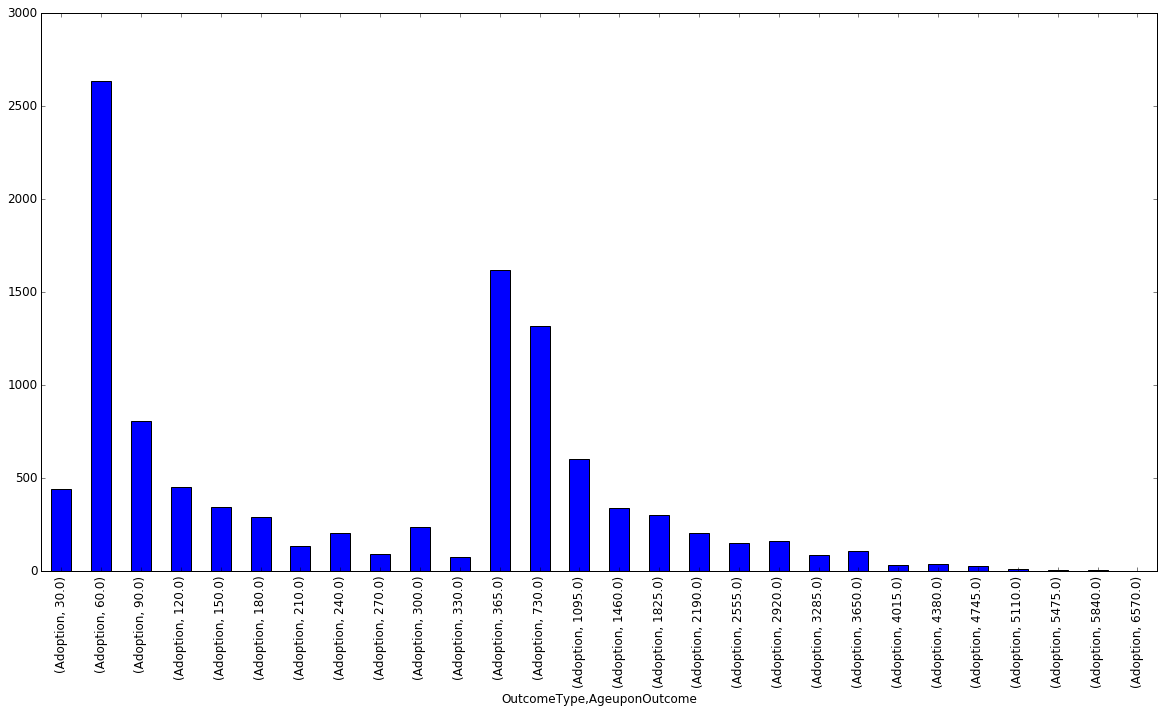

In [98]:
age = train[['OutcomeType', 'AgeuponOutcome']]
grouped = age[train['OutcomeType'] == 'Adoption'].groupby(['OutcomeType', 'AgeuponOutcome'])
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 20, 10
grouped.size().plot.bar()

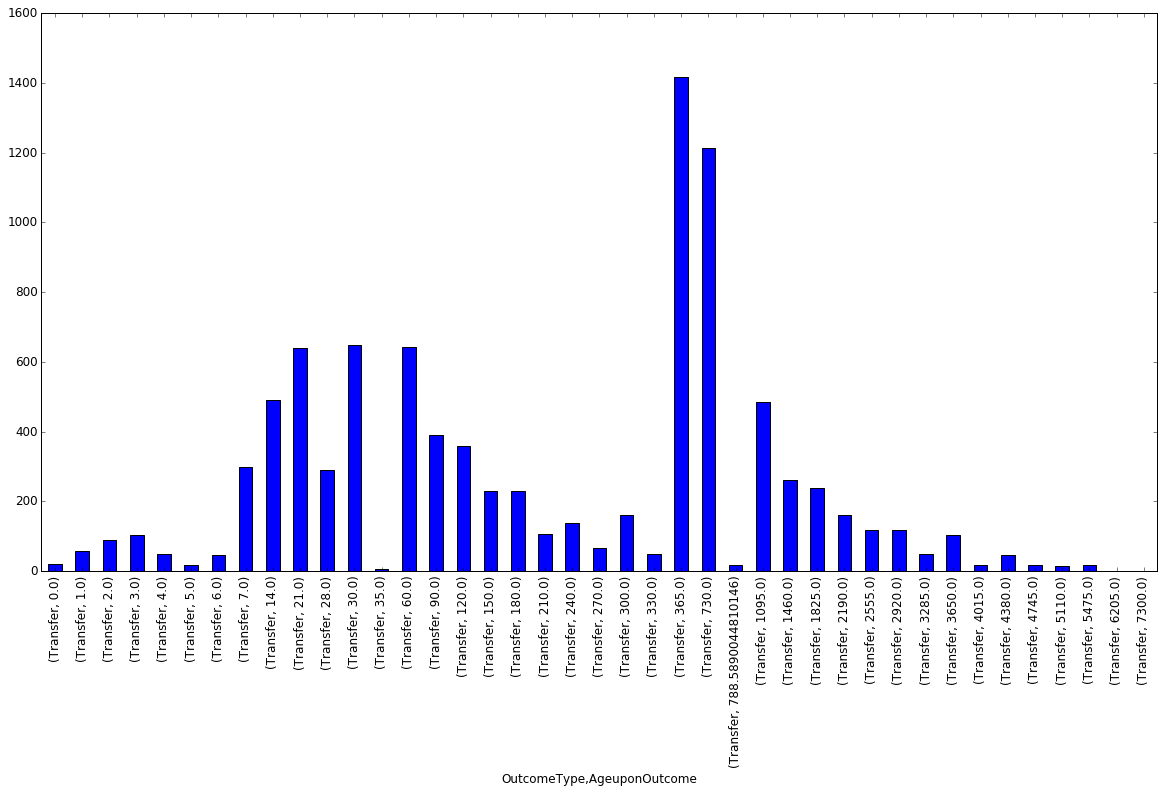

In [99]:
age = train[['OutcomeType', 'AgeuponOutcome']]
grouped = age[train['OutcomeType'] == 'Transfer'].groupby(['OutcomeType', 'AgeuponOutcome'])
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 20, 10
grouped.size().plot.bar()

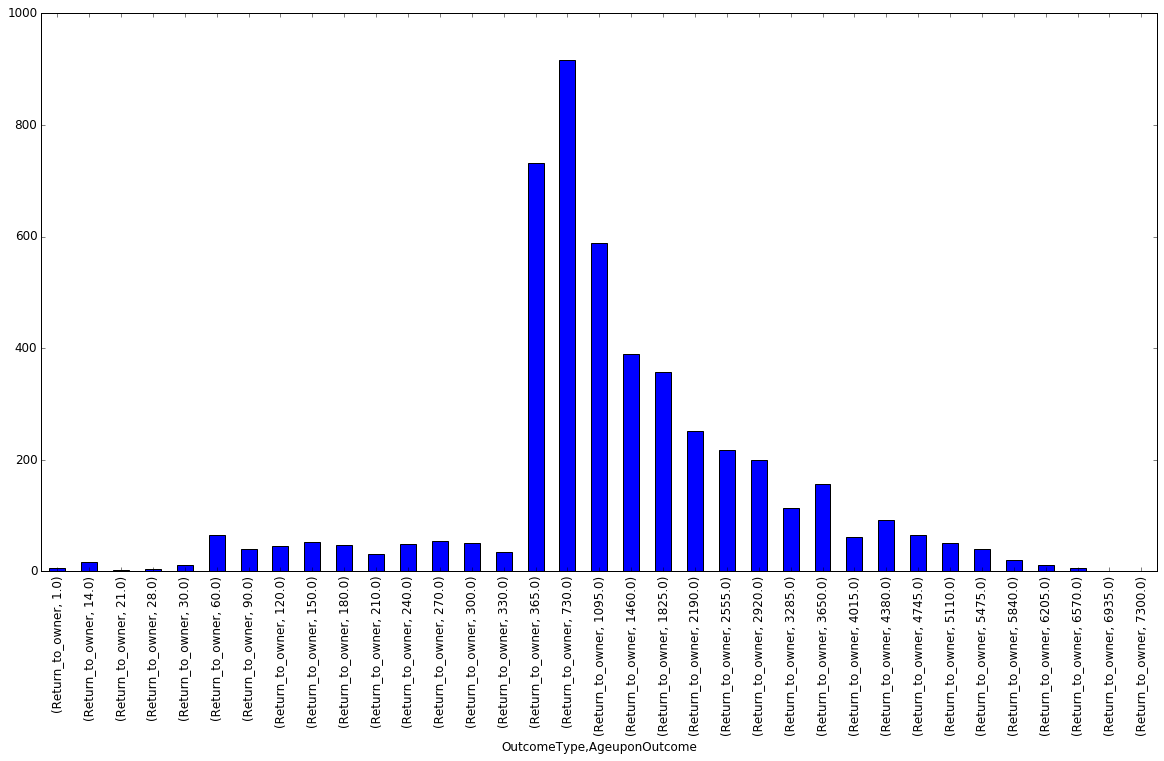

In [100]:
age = train[['OutcomeType', 'AgeuponOutcome']]
grouped = age[train['OutcomeType'] == 'Return_to_owner'].groupby(['OutcomeType', 'AgeuponOutcome'])
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 20, 10
grouped.size().plot.bar()

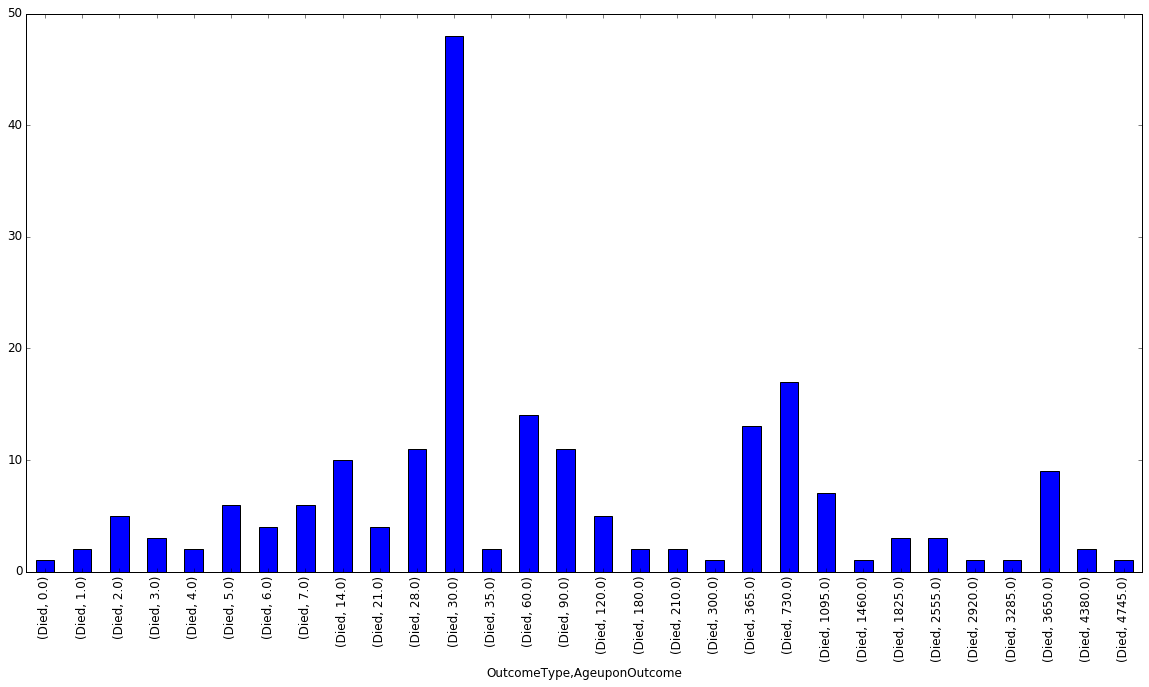

In [101]:
age = train[['OutcomeType', 'AgeuponOutcome']]
grouped = age[train['OutcomeType'] == 'Died'].groupby(['OutcomeType', 'AgeuponOutcome'])
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 20, 10
grouped.size().plot.bar()

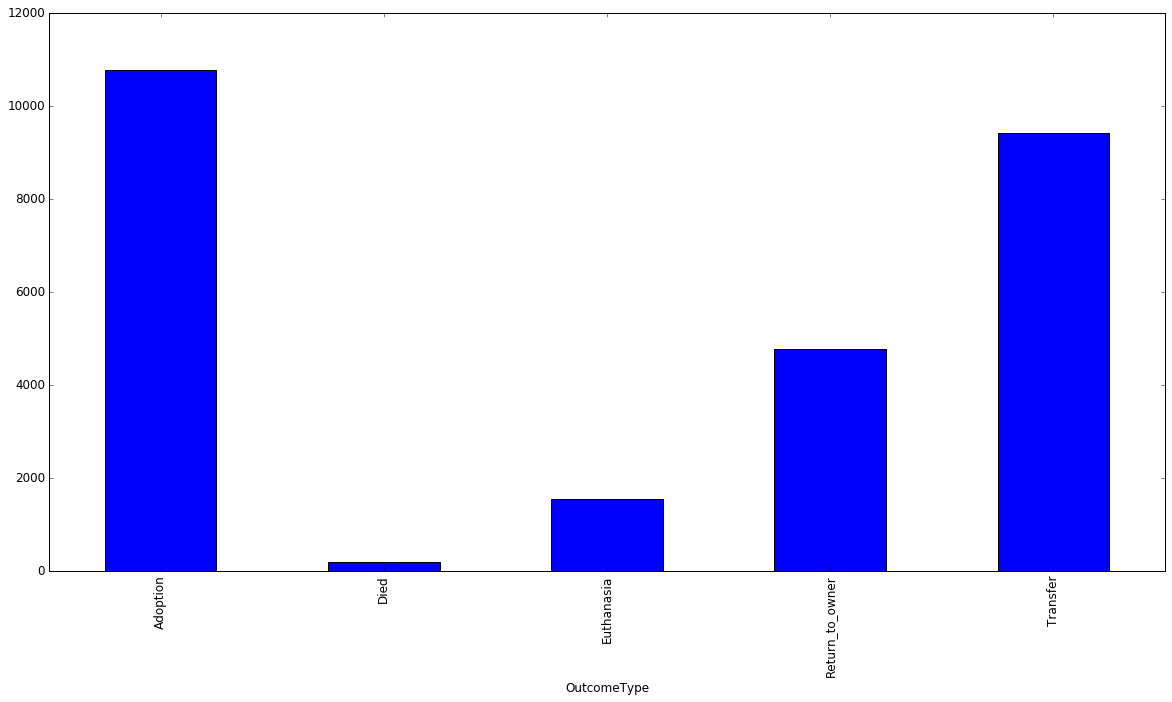

In [102]:
age = train[['OutcomeType', 'AgeuponOutcome']]
grouped = age.groupby(['OutcomeType'])
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 20, 10
grouped.size().plot.bar()

In [24]:
categorical_features = ['AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Year', 'Month']
remove_features = ['DateTime', 'OutcomeSubtype', 'OutcomeType', 'Color', 'WeekDay']
all_X = flatten(all_df, categorical_features)

train_X = all_X[all_X['OutcomeType'].notnull()]
test_X = all_X[all_X['OutcomeType'].isnull()]

le = preprocessing.LabelEncoder()
train_y = le.fit_transform(train_X['OutcomeType'].astype('category'))

train_X = remove(train_X, remove_features)
test_X = remove(test_X, remove_features)


print(train_X.shape)
print(test_X.shape)
# for col in sorted(list(map(lambda x: str(x), train_X.columns))):
#     print(col)
train_X[:3]

(26729, 330)
(11456, 330)


,Name,BreedMix,BreedCount,Breed Jack Russell Terrier,Breed Greyhound,Breed Standard Poodle,Breed Norwich Terrier,Breed Tonkinese,Breed American Shorthair,Breed Black,...,3,4,5,6,7,8,9,10,11,12
A671945,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A656520,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
A686464,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_X, train_y, test_size=0.3, random_state=248)

In [26]:
parameters = {'n_estimators': [1000]}
model = ensemble.RandomForestClassifier(n_jobs=6)

print("# Tuning hyper-parameters")
print()

clf = grid_search.GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(metrics.classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'n_estimators': 1000}

Grid scores on development set:

0.625 (+/-0.004) for {'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.65      0.80      0.72      3278
          1       0.23      0.05      0.08        60
          2       0.40      0.12      0.18       449
          3       0.45      0.39      0.42      1448
          4       0.69      0.65      0.67      2784

avg / total       0.61      0.63      0.61      8019




In [27]:
parameters = {'n_estimators': [200, 300, 400, 500]}
parameters = {'reg_alpha': [10], 'reg_lambda': [50], 'n_estimators': [400]}
model = xgb.XGBClassifier()

print("# Tuning hyper-parameters")
print()

clf = grid_search.GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(metrics.classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'reg_alpha': 10, 'n_estimators': 400, 'reg_lambda': 50}

Grid scores on development set:

0.645 (+/-0.011) for {'reg_alpha': 10, 'n_estimators': 400, 'reg_lambda': 50}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.64      0.86      0.73      3278
          1       0.00      0.00      0.00        60
          2       0.57      0.12      0.20       449
          3       0.47      0.40      0.43      1448
          4       0.75      0.62      0.68      2784

avg / total       0.64      0.65      0.63      8019




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [156]:
model = ensemble.RandomForestClassifier(n_jobs=6, n_estimators=500)
model = xgb.XGBClassifier(n_estimators=400)
model.fit(train_X, train_y)
predict = model.predict_proba(test_X)

In [163]:
predict[:5]

array([[  8.07643980e-02,   2.71259341e-03,   5.50088584e-02,
          2.64275253e-01,   5.97238839e-01],
       [  7.10493565e-01,   1.02598080e-03,   1.16866417e-02,
          1.86985239e-01,   8.98085460e-02],
       [  4.43874061e-01,   1.67012075e-03,   1.08078271e-02,
          1.41801894e-01,   4.01846141e-01],
       [  1.30722210e-01,   5.86139620e-04,   4.03593592e-02,
          2.74414301e-01,   5.53918004e-01],
       [  4.10158396e-01,   6.37221325e-04,   1.61029156e-02,
          3.94401640e-01,   1.78699791e-01]], dtype=float32)

In [164]:
output = pd.read_csv("sample_submission.csv")
output['Adoption'], output['Died'], output['Euthanasia'], output['Return_to_owner'], output['Transfer'] = predict[:,0], predict[:,1], predict[:,2], predict[:,3], predict[:,4]
output.to_csv("actual_submission.csv", index=False)